# Task 1

From the coursework documnet:

The first task tests your Python skills. You need to develop a simple game consisting of a rectangular grid (of size height x width ) where each cell has a random integer value between 0 and 9. An agent starts at the upper-left corner of the grid and must reach the lower-right corner of the grid as fast as possible.

## External Sources Used
- Numpy documentation: https://docs.scipy.org/doc//numpy-1.10.4/reference/generated/numpy.random.choice.html detailing how to make a random choice between elements in an array, given an array of probabilities defining the probability to pick to each element. Used in 1 line of code when building the Ant_Agent (which plays the game using Ant Colony Optimization).
- Matplot lib documnetation: https://matplotlib.org/3.1.1/gallery/pie_and_polar_charts/pie_features.html detailing how to plot a simple pie chart. Used in 1 method "plot_ant_failures", in the Agent_Comparer, to visualize the success rate of the Ant_Agent when playing the game.


In [1]:
import numpy as np
import random
from abc import ABC, abstractmethod
from statistics import mean
import matplotlib.pyplot as plt

In [2]:
class Game():
    def __init__(self, width, height):
        self.width = width
        self.height = height
        self.maze = (np.random.rand(self.height, self.width) * 10).astype('int')
        self.start = self.maze[0][0]
        self.end = self.maze[self.height - 1][self.width - 1]
        self.game_complete = False
        # Pointer
        self.pointer_x = 0
        self.pointer_y = 0
        self.pointer_val = self.maze[0][0]
        self.pointer = f"Currently at [{0}, {0}], of cost {self.start}"
        # Records
        self.steps_taken = 0
        self.time_spent = 0
    

    #Move the pointer from its current position, to the position passed in as parameters (x, y)
    def move_pointer(self, x_pos, y_pos):
        # Check if x_pos and y_pos are legal (step size of 1 unit, that does not exceed maze boundary)
        if(abs(x_pos - self.pointer_x) > 1 or (x_pos >= self.width or x_pos < 0)):
            print("X Step too large")
            return
        if(abs(y_pos - self.pointer_y) > 1 or (y_pos >= self.height or y_pos < 0)):
            print("Y Step too large")
            return
        # Check that step is not diagonal (i.e. it is not the case that both x and y positions have changed)
        if((x_pos != self.pointer_x) and (y_pos != self.pointer_y)):
            print("Cannot move diagonally!")
            return
        # If all is legal, make the step
        # Update records
        self.steps_taken += 1
        self.time_spent += self.pointer_val
        # Move pointer
        self.pointer_x = x_pos
        self.pointer_y = y_pos
        self.pointer_val = self.maze[y_pos][x_pos]
        self.pointer = f"Currently at [{x_pos}, {y_pos}], of cost {self.pointer_val}"
        print(f"{self.pointer}")
        # Check if after the move, the agent has won the game.
        if(self.pointer_x == (self.width - 1) and self.pointer_y == (self.height - 1)):
            self.game_complete = True
            print("Won the game! 🥳")
    

    #Reset the game
    def reset(self):
        print("Resetting game...")
        self.game_complete = False
        self.pointer_x = 0
        self.pointer_y = 0
        self.steps_taken = 0
        self.time_spent = 0
        self.pointer = f"Currently at [{0}, {0}], of cost {self.start}"
        print(self.pointer)
    
    def get_cost(self, x_pos, y_pos):
        return self.maze[y_pos][x_pos]


    #Given a point on the grid (x, y), return an array of neighboring coordinates [[x1, y1], [x2, y2], [x3, y3]...etc.]
    def get_neighbors(self, x_pos, y_pos):
        x_plus = x_pos + 1 if x_pos < (self.width - 1) else None
        x_minus = x_pos - 1 if x_pos > 0 else None
        y_plus = y_pos + 1 if y_pos < (self.height - 1) else None
        y_minus = y_pos - 1 if y_pos > 0 else None
        
        above = [x_pos, y_minus]
        below = [x_pos, y_plus]
        left = [x_minus, y_pos]
        right = [x_plus, y_pos]

        neighbors = [above, below, left, right]

        result = [ n for n in neighbors if (n[0] != None and n[1] != None)]

        return result




In [3]:
#Test game
game = Game(width=5, height=5)
print(f"{game.maze}\n")

print("After a move to x=1, y=0")
game.move_pointer(x_pos=1, y_pos=0)

[[2 3 9 8 1]
 [0 7 5 0 0]
 [9 9 4 1 4]
 [5 7 9 2 5]
 [8 6 8 2 6]]

After a move to x=1, y=0
Currently at [1, 0], of cost 3


# Agents

After implementing the game, we are tasked with developing agents to play it. All agents will conform to the Agent abstract base class. They must all take a game (type Game) into their constructor, and implement a method play_game() which plays the game that the agent was initialized with, as well as the score() method, which prints the agent's performance in completing the game.

In [4]:
class Agent(ABC):
    @abstractmethod
    def __init__(self, game: Game):
        self.game = game
        self.steps_taken = 0
        self.time_spent = 0
        
    @abstractmethod
    def play_game(self):
        pass
    
    @abstractmethod
    def score(self):
        pass

## Random Agent

The first agent we need to develop is a "basline agent". The baseline agent needs to be superior to a random agent in reaching the end of the game. We implement a random agent to test their performance for comparison's sake.

In [5]:
class Random_Agent(Agent):
    def __init__(self, game: Game):
        self.game = game
        self.steps_taken = 0
        self.time_spent = 0
    
    def play_game(self):
        self.game.reset()
        # While the game is not complete...
        while(not self.game.game_complete):
            # Determine if we're moving along the y axis (if not, the step is along the x axis)
            move_y = random.choice((0, 1))
            # Determine if our direction is negative or positive (e.g. backwards along the y axis vs forwards along the y axis)
            direction = random.choice((-1, 1))

            # If the move is along the x axis, ensure the move does not exceed the boundaries of the maze (in that case, go back to start of loop)
            # Then, move in the random direction alongside the x axis
            if(move_y == 0):
                new_x = self.game.pointer_x + direction
                new_y = self.game.pointer_y
                if(new_x >= self.game.width or new_x < 0):
                    continue
                self.game.move_pointer(x_pos=new_x, y_pos=new_y)
            #Do the same if it were determined that the move should be along the y axis...
            else:
                new_x = self.game.pointer_x
                new_y = self.game.pointer_y + direction
                if(new_y >= self.game.height or new_y < 0):
                    continue
                self.game.move_pointer(x_pos=new_x, y_pos=new_y)
        
        self.steps_taken = self.game.steps_taken
        self.time_spent = self.game.time_spent
        return

    def score(self):
        print(f"\nTime spent: {self.time_spent}, Steps taken: {self.steps_taken}\n")


# Baseline Agent

Our baseline agent will move diagonally towards the bottom right. Once it reaches an edge, it then moves (either downwards or across to the left, depending on maze dimensions), until it reaches the end point

In [6]:
class Baseline_Agent(Agent):
    def __init__(self, game: Game):
        self.game = game
        self.steps_taken = 0
        self.time_spent = 0
    

    def play_game(self):
        self.game.reset()
        while(not self.game.game_complete):
            # If we reached the bottom edge, move across to the right
            if (self.game.pointer_y == self.game.height - 1):
                new_x = self.game.pointer_x + 1
                new_y = self.game.pointer_y
                self.game.move_pointer(x_pos=(new_x), y_pos=(new_y))

            # Else if we reached the right edge, move downwards
            elif (self.game.pointer_x == self.game.width - 1):
                new_x = self.game.pointer_x
                new_y = self.game.pointer_y + 1
                self.game.move_pointer(x_pos=(new_x), y_pos=(new_y))

            # Else, move diagonally, by going through two steps
            else:
                new_x_1 = self.game.pointer_x + 1
                new_y_1 = self.game.pointer_y
                self.game.move_pointer(x_pos=(new_x_1), y_pos=(new_y_1))
                new_x_2 = self.game.pointer_x
                new_y_2 = self.game.pointer_y + 1
                self.game.move_pointer(x_pos=(new_x_2), y_pos=(new_y_2))

        self.steps_taken = self.game.steps_taken
        self.time_spent = self.game.time_spent
        return
    
    def score(self):
        print(f"\nTime spent: {self.time_spent}, Steps taken: {self.steps_taken}\n")
            

# Dijkstra's Algorithm

We build an agent that plays the game using Dijkstra's algorithm.    

In [7]:
class Dijkstra_Agent(Agent):
    def __init__(self, game: Game):
        self.game = game
        self.steps_taken = 0
        self.time_spent = 0

        self.number_of_nodes = self.game.width * self.game.height
        self.current_node = f"{0},{0}"
        self.visted_nodes = []
        self.path = []

        #Initialize dictionary info, whose schema looks like:
        #      {“node”: {previous: “node”, cost: 0}...}
        # Where "node" is a string representation of the coordinates of a cell on the grid... e.g. "0,0" for [0, 0]
        self.info = {}
        # Fill info with values given the game's dimensions
        for w in range(self.game.width):
            for h in range(self.game.height):
                if(w == 0 and h == 0 ):
                    self.info[f"{w},{h}"] = {"prev": None, "cost": 0}
                else:
                    self.info[f"{w},{h}"] = {"prev": None, "cost": float("inf")}
    

    def play_game(self):
        self.game.reset()
        # Fills in self.info "cost" and "prev" values for each node
        self.explore()
        # Uses self.info to build up the quickest path to endpoint
        self.build_path()
        # Play the game by following the path
        for n in self.path:
            move_cor = self.string_to_coor(n)
            self.game.move_pointer(x_pos=move_cor[0], y_pos=move_cor[1])
        
        self.steps_taken = self.game.steps_taken
        self.time_spent = self.game.time_spent
        

    def build_path(self):
        # Initialize "node" to equal the end point
        node = f"{self.game.width - 1},{self.game.height - 1}"
        # Working backwards, check the value for "prev" in self.info, corresponding to the node defined above
        # This will give us the quickest path going backwards, starting from the end, and reaching the start
        # Insert every encountered node on this path going backwards, to the front of self.path. 
        # The end result is a list of corrodinates for the quickest path, from start to end
        while not node == f"{0},{0}":
            self.path.insert(0, node)
            node = self.info[node]["prev"]


    def explore(self):
        #Base case - if we've visted all nodes, we're done
        if len(self.visted_nodes) >= self.number_of_nodes:
            return

        #Convert self.current_node into numerical format using self.string_to_coor.. e.g. "0,0" -> [0, 0]
        current_node_numb = self.string_to_coor(self.current_node)
        #Get all the neighbors of self.current_node (helper function that outputs all neighbors is in Game class)
        current_neighbors = self.game.get_neighbors(current_node_numb[0], current_node_numb[1])

        #For each neighbor that has not been previously visited (i.e. is not in self.visited_nodes) do the following:
        # - Initialize a variable called "current_cost". 
        #   This equals current_node's cost (total cost from start to current_node), plus the cost of traveling to this neighbor from current_node
        # - If value for the variable "current_cost" is less than the neighbor's cost as specified in self.info (total cost from start to that neighbor), 
        #   set info["neighbor"]["cost"] to current_cost, and info["neighbor"]["prev"] to current_node
        for n in current_neighbors:
            if not n in self.visted_nodes:
                current_cost = self.info[self.current_node]["cost"] + self.game.get_cost(x_pos=n[0], y_pos=n[1])
                if current_cost <  self.info[f"{n[0]},{n[1]}"]["cost"]:
                    self.info[f"{n[0]},{n[1]}"]["cost"] = current_cost
                    self.info[f"{n[0]},{n[1]}"]["prev"] = self.current_node
        
        # Tick current_node off by adding it to self.visited_nodes
        self.visted_nodes.append(self.current_node)

        # Set current_node to equal to the non visited node with the lowest cost as specified in info (total cost from start to that node)
        self.update_current_node()

        #Recursivley call explore again
        self.explore()


    def update_current_node(self):
        if len(self.visted_nodes) >= self.number_of_nodes:
            return

        least_cost = float("inf")
        least_cost_node = ""

        for n in self.info:
            if (not n in self.visted_nodes and self.info[n]["cost"] < least_cost):
                least_cost = self.info[n]["cost"]
                least_cost_node = n
        
        self.current_node = least_cost_node


    #Takes a string s, and returns an array of the corrdinates... e.g. "0,0" -> [0, 0]
    def string_to_coor(self, input):
        split_string = input.split(",")
        for i in range(len(split_string)):
            split_string[i] = int(split_string[i])
        return split_string

    
    def score(self):
        print(f"\nTime spent: {self.time_spent}, Steps taken: {self.steps_taken}\n")

            



# Ant Colony Optimization Algorithm
We build an agent that plays the game using any colony optimization

In [8]:
class Ant_Agent(Agent):
    def __init__(self, game: Game, ants=10, batches=10, eva_factor=0.5, q_const=1):
        self.game = game
        self.steps_taken = 0
        self.time_spent = 0

        self.ants= ants
        self.batches = batches
        self.end_point = [(self.game.width - 1), (self.game.height - 1)]
        self.visited_nodes = []
        self.eva_factor = eva_factor
        self.q_const = q_const
        self.game_failed = False

        self.ant_info = {}
        for ant in range(self.ants):
            self.ant_info[ant] = [[0,0]]
        
        self.node_p_levels = {}
        for w in range(self.game.width):
            for h in range(self.game.height):
                if(w == 0 and h == 0 ):
                    self.node_p_levels[f"{w},{h}"] = 0
                else:
                    self.node_p_levels[f"{w},{h}"] = 0
    

    # The agent explores the maze with ants (self.explore()). 
    # Once a a path is built with phermones, the player then moves accorss this path (self.move())
    def play_game(self):
        self.game.reset()
        self.explore()
        print("\nBegin playing...")
        while (not self.game.game_complete):
            self.move()
            if(self.game_failed):
                return

        self.steps_taken = self.game.steps_taken
        self.time_spent = self.game.time_spent

    # A single step of the player accross the path with the highest phermone level. 
    # The player is not allowed to vist the same location more than once.
    def move(self):
        loc = [self.game.pointer_x, self.game.pointer_y]

        neighbors = self.game.get_neighbors(x_pos=loc[0], y_pos=loc[1])
        neighbors = [ n for n in neighbors if not n in self.visited_nodes]

        if(len(neighbors) == 0):
            print("Game reached dead end")
            self.game_failed = True
            return

        max_p_level = self.node_p_levels[f"{neighbors[0][0]},{neighbors[0][1]}"]
        max_p_node = neighbors[0]

        for n in neighbors:
            if self.node_p_levels[f"{n[0]},{n[1]}"] > max_p_level:
                max_p_level = self.node_p_levels[f"{n[0]},{n[1]}"]
                max_p_node = n
        
        if self.end_point in neighbors:
            max_p_node = self.end_point

        self.visited_nodes.append(max_p_node)
        self.game.move_pointer(x_pos=max_p_node[0], y_pos=max_p_node[1])


    # Release ants in batches. Ants explore maze, until they reach the end_point
    # To make a decision to move from their current location, to the next, each ant takes into consideration the following:
    #  - If a neighboring location is the end_point, the ant will go to it directly
    #  - If neighboring locations have varying phermone levels, it will, on a probablistic basis, prefer locations with higher phermone level
    #  - If all neighboring locations have an equal phermone level (or all locations have no phermone) an ant randomly chooses its next location 
    # An ant is allowed to visit the same location more than once.
    # Once all ants in a batch reach the endpoint, update phermone level of the path they took from the beginning to the end. 
    # The higher the total cost of the path the ant took from start to end, the less the phermone level of that path will be after the batch.
    def explore(self):
        for b in range(self.batches):
            # Let each ant come to a solution
            print("Releasing the ants...")
            for ant in range(self.ants):
                current_ant_loc = self.ant_info[ant][len(self.ant_info[ant]) - 1]
                while(not current_ant_loc == self.end_point):
                    chosen_neighbor = self.select_neighbor(loc=current_ant_loc)
                    self.ant_info[ant].append(chosen_neighbor)
                    current_ant_loc = chosen_neighbor
            # Update phermone levels
            print("Updating Phermones...")
            for ant in range(self.ants):
                list_of_costs = []
                for n in self.ant_info[ant]:
                    cost = self.game.get_cost(x_pos=n[0], y_pos=n[1])
                    if(not cost == 0):
                        list_of_costs.append(self.q_const / cost)
                    else:
                        list_of_costs.append(0)
                for n in self.ant_info[ant]:
                    current_p_level = self.node_p_levels[f"{n[0]},{n[1]}"]
                    self.node_p_levels[f"{n[0]},{n[1]}"] = (1 - self.eva_factor) * current_p_level + sum(list_of_costs)
    

    #A function that takes a location on the grid, and selects an approrpaite neighbor for the ant to travel to
    def select_neighbor(self, loc):
        neighbors = self.game.get_neighbors(x_pos=loc[0], y_pos=loc[1])

        #If the end_point is a neighbor, select it
        if(self.end_point in neighbors):
            return self.end_point

        #For each n in neighbors, build a probabilities array with the probability to take that neighbor
        #Probability to select neighbor is node_p_levels[n] / total_neighbor_p_level

        #First calcuate total_neighbor_p_level
        total_neighbor_p_level = 0
        for n in neighbors:
            total_neighbor_p_level += self.node_p_levels[f"{n[0]},{n[1]}"]
        
        #If all neighbors have p_level of 0, chose a random neighbor to go to
        if total_neighbor_p_level == 0:
            return random.choice(neighbors)
        
        #Else choose a neighbor based on how high the p_levels are relative to other neighbors
        #Build an array of probabilities (we need to build a stringified version of neighbors to use np.random.choice as well)
        #Reference: https://docs.scipy.org/doc//numpy-1.10.4/reference/generated/numpy.random.choice.html
        probabilities = []
        neighbors_s = []
        for n in neighbors:
           probabilities.append(self.node_p_levels[f"{n[0]},{n[1]}"] / total_neighbor_p_level)
           neighbors_s.append(f"{n[0]},{n[1]}")
        
        return self.string_to_coor(np.random.choice(neighbors_s, p=probabilities))


    #Takes a string s, and returns an array of the corrdinates... e.g. "0,0" -> [0, 0]
    def string_to_coor(self, input):
        split_string = input.split(",")
        for i in range(len(split_string)):
            split_string[i] = int(split_string[i])
        return split_string
    
    def score(self):
        if(self.game_failed):
            print("\nGame has failed 😑\n")
        else:
            print(f"\nTime spent: {self.time_spent}, Steps taken: {self.steps_taken}\n")


# Comparing Agents 

We build a class, Agent_Comparer, that takes dimensions for a game (width and height), as well as a number_of_rounds. 

The Agent_Comparer uses the dimesions to build a game. It then allows each of the above agents to play the game number_of_rounds times. It takes the mean of each agent's score and plots it on a bar chart, comparing them.

In [9]:
class Agent_Comparer():
    def __init__(self, width, height, number_of_rounds, ants=30, batches=10, eva_factor=0.5, q_const=1):
        self.width = width
        self.height = height
        self.number_of_rounds = number_of_rounds
        self.ants = ants
        self.batches = batches
        self.eva_factor = eva_factor
        self.q_const = q_const
        self.game = Game(width=self.width, height=self.height)

        self.random_agent_scores = []
        self.baseline_agent_score = 0
        self.djikstra_agent_score = 0
        self.ant_agent_scores = []
        self.ant_agent_failures = 0

    
    def compare(self):

        #Baseline Agent
        print(f"\nBaseline Agent:")
        baseline_agent = Baseline_Agent(self.game)
        baseline_agent.play_game()
        self.baseline_agent_score = baseline_agent.time_spent

        #Djikstra's Agent
        print(f"\nDjikstra's Agent:")
        d_agent = Dijkstra_Agent(self.game)
        d_agent.play_game()
        self.djikstra_agent_score = d_agent.time_spent

        for n in range(self.number_of_rounds):
            print(f"Round {n}:\n")

            #Random agent
            print(f"\nRandom Agent:")
            random_agent = Random_Agent(self.game)
            random_agent.play_game()
            self.random_agent_scores.append(random_agent.time_spent)

            #Ant Agent
            print(f"\nAnt Agent:")
            ant_agent = Ant_Agent(game=game, ants=self.ants, batches=self.batches, eva_factor=self.eva_factor, q_const=self.q_const)
            ant_agent.play_game()
            if ant_agent.game_failed:
                self.ant_agent_failures += 1
            else:
                self.ant_agent_scores.append(ant_agent.time_spent)


    def print_results(self):
        print(f"\nResuts, The lower the better!")
        print(f"Random agent mean score is {mean(self.random_agent_scores)}")
        print(f"Baseline agent mean score is {self.baseline_agent_score}")
        print(f"Djikstra's agent mean score is {self.djikstra_agent_score}")

        if(len(self.ant_agent_scores) > 0):
            print(f"Ant agent mean score (excluding failures) is {mean(self.ant_agent_scores)}")
        print(f"Ant agent failed {self.ant_agent_failures} times, out of {self.number_of_rounds}")
    

    def plot_results(self):
        mean_random = mean(self.random_agent_scores)
        mean_baseline = self.baseline_agent_score
        mean_dj = self.djikstra_agent_score

        plt.figure(figsize=[10, 5])
        plt.title(f"Comparing Various Path Finding Algorithms ({self.number_of_rounds} Iterations, {self.width}x{self.height} Maze)")
        plt.xlabel("Algorithm")
        plt.ylabel("Mean Cost of Paths Chosen by Algorithm")
        if len(self.ant_agent_scores) > 0:
            mean_ant = mean(self.ant_agent_scores)
            plt.bar(["Random", "Baseline", "Djikstra's", "Ant"], [mean_random, mean_baseline, mean_dj, mean_ant])
            plt.show()
        
        else:
            plt.bar(["Random", "Baseline", "Djikstra's"], [mean_random, mean_baseline, mean_dj])
            plt.show()
    

    def plot_ant_failures(self):
        #Reference for Pie Chart: https://matplotlib.org/3.1.1/gallery/pie_and_polar_charts/pie_features.html
        sucess_no = self.number_of_rounds - self.ant_agent_failures
        failure_no = self.ant_agent_failures
        frequencies = [sucess_no, failure_no]
        labels = ["Success", "Failure"]

        fig1, ax1 = plt.subplots()
        ax1.pie(frequencies, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90)
        ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
        plt.title("Ratio of Succees, to Failure, For Ant Colony Algorithm in Solving Maze")
        plt.show()



## Compring 100 Rounds on 3x3 Grid

In [14]:
%%time

comparer = Agent_Comparer(width=3, height=3, number_of_rounds=100, ants=50, batches=3)
comparer.compare()


3], of cost 5
Currently at [1, 3], of cost 7
Currently at [1, 2], of cost 9
Currently at [0, 2], of cost 9
Game reached dead end
Round 83:


Random Agent:
Resetting game...
Currently at [0, 0], of cost 4
Currently at [1, 0], of cost 9
Currently at [0, 0], of cost 4
Currently at [0, 1], of cost 1
Currently at [1, 1], of cost 3
Currently at [2, 1], of cost 7
Currently at [1, 1], of cost 3
Currently at [1, 2], of cost 0
Currently at [0, 2], of cost 9
Currently at [0, 1], of cost 1
Currently at [1, 1], of cost 3
Currently at [1, 2], of cost 0
Currently at [0, 2], of cost 9
Currently at [1, 2], of cost 0
Currently at [2, 2], of cost 3
Won the game! 🥳

Ant Agent:
Resetting game...
Currently at [0, 0], of cost 2
Releasing the ants...
Updating Phermones...
Releasing the ants...
Updating Phermones...
Releasing the ants...
Updating Phermones...

Begin playing...
Currently at [0, 1], of cost 0
Currently at [0, 2], of cost 9
Currently at [0, 3], of cost 5
Currently at [0, 4], of cost 8
Currently a

In [15]:
comparer.print_results()


Resuts, The lower the better!
Random agent mean score is 83
Baseline agent mean score is 23
Djikstra's agent mean score is 7
Ant agent mean score (excluding failures) is 53
Ant agent failed 43 times, out of 100


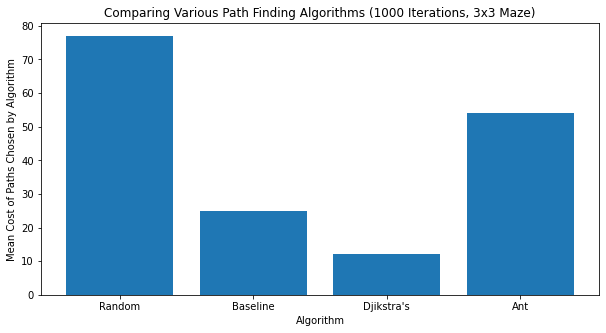

In [12]:
comparer.plot_results()

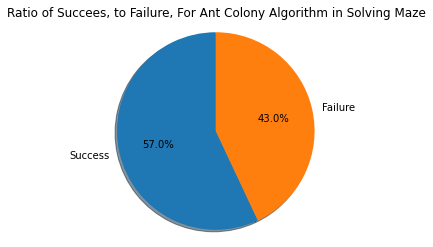

In [16]:
comparer.plot_ant_failures()